# Advanced usage

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger


import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


from sklearn import datasets

iris = datasets.load_iris()
x, y = iris["data"], iris["target"]

print("Data set contains %d samples with %d features" % x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

Data set contains 150 samples with 4 features
100 training samples
50 test samples


## Create a t-SNE embedding

In [4]:
import logging
import operator
from functools import reduce

import numpy as np
import scipy.sparse as sp

#from . import nearest_neighbors

log = logging.getLogger(__name__)

import openTSNE
from openTSNE import nearest_neighbors
from openTSNE.affinity import PerplexityBasedNN, joint_probabilities_nn, MultiscaleMixture, FixedSigmaNN

from Orange.widgets.bakk.additional_files.algorithms import annoy, nearpy, nmslib


def build_knn_index(
    data, method, k, metric, metric_params=None, n_jobs=1, random_state=None
):
    methods = {
        "nndescent": nearest_neighbors.NNDescent,
        "balltree": nearest_neighbors.BallTree,
        "annoy": annoy.Annoy,
        "hnsw": nmslib.Hnsw,
        "sw-graph": nmslib.SWGraph,
        #"vp-tree": nmslib.VPTree,
        "napp": nmslib.NAPP,
        #"simple_invindx": nmslib.SimpleInvindx,
        "brute_force": nmslib.BruteForce,
        "nearpy": nearpy.NearPy,
    }
    if isinstance(method, nearest_neighbors.KNNIndex):
        knn_index = method

    elif method not in methods:
        raise ValueError(
            "Unrecognized nearest neighbor algorithm `%s`. Please choose one "
            "of the supported methods or provide a valid `KNNIndex` instance."
            % method
        )
    else:
        knn_index = methods[method](
            metric=metric,
            metric_params=metric_params,
            n_jobs=n_jobs,
            random_state=random_state,
        )

    neighbors, distances = knn_index.build(data, k=k)

    return knn_index, neighbors, distances


class MultiANNPerplexityBasedNN(PerplexityBasedNN):
    """Compute affinities using nearest neighbors.
    """

    #super init !
    def __init__(
        self,
        data,
        perplexity=30,
        method="annoy",
        metric="euclidean",
        metric_params=None,
        symmetrize=True,
        n_jobs=1,
        random_state=None,
    ):
        self.n_samples = data.shape[0]
        self.perplexity = self.check_perplexity(perplexity)

        # self.knn_index = build_knn_index(
        #     data, method, metric, metric_params, n_jobs, random_state
        # )
        #
        # # Find and store the nearest neighbors so we can reuse them if the
        # # perplexity is ever lowered
        # k_neighbors = min(self.n_samples - 1, int(3 * self.perplexity))
        # self.__neighbors, self.__distances = self.knn_index.query_train(
        #     data, k=k_neighbors
        # )

        k_neighbors = min(self.n_samples - 1, int(3 * self.perplexity))
        self.knn_index, self.__neighbors, self.__distances = build_knn_index(
            data, method, k_neighbors, metric, metric_params, n_jobs, random_state
        )

        self.P = joint_probabilities_nn(
            self.__neighbors,
            self.__distances,
            [self.perplexity],
            symmetrize=symmetrize,
            n_jobs=n_jobs,
        )

        self.n_jobs = n_jobs

**3. Construct the `TSNEEmbedding` object**

In [11]:
%time init_train = initialization.pca(x_train, random_state=42)

%time 
affinities_train = MultiANNPerplexityBasedNN(
    x_train,
    perplexity=30,
    method="nearpy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

%time

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

CPU times: user 708 µs, sys: 70 µs, total: 778 µs
Wall time: 722 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
(100, 4)
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


**4. Optimize embedding**

1. Early exaggeration phase

Iteration   50, KL divergence  1.6603, 50 iterations in 7.1321 sec
Iteration  100, KL divergence  1.6074, 50 iterations in 1.5160 sec
Iteration  150, KL divergence  1.8448, 50 iterations in 3.8254 sec
Iteration  200, KL divergence  1.8532, 50 iterations in 1.9233 sec
Iteration  250, KL divergence  1.7739, 50 iterations in 2.4243 sec
CPU times: user 15.8 s, sys: 568 ms, total: 16.3 s
Wall time: 16.8 s


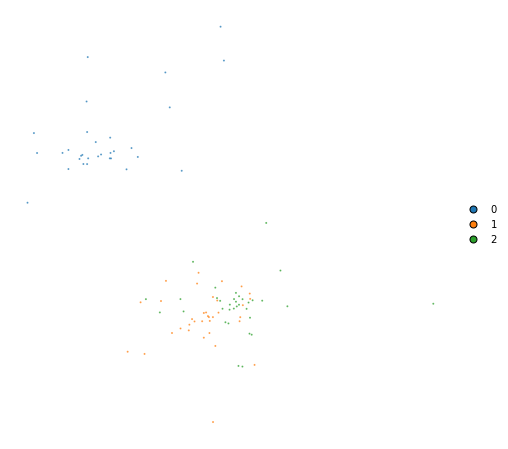

In [12]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

import utils
utils.plot(embedding_train_1, y_train)

# %time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

# utils.plot(embedding_train_2, y_train)

# %%time
# embedding_test = embedding_train_2.prepare_partial(
#    x_test,
#    initialization="median",
#    k=25,
#    perplexity=5,
#)

#utils.plot(embedding_test, y_test)

# %%time
#embedding_test_1 = embedding_test.optimize(
#   n_iter=100,
#    learning_rate=1,
#    exaggeration=2,
#    momentum=0,
#)

#utils.plot(embedding_test_1, y_test)

#fig, ax = plt.subplots(figsize=(12, 8))
#utils.plot(embedding_train_2, y_train, alpha=0.25, ax=ax)
#utils.plot(embedding_test_1, y_test, alpha=0.75, ax=ax)

---